# 四种天气图片的分类和预训练网络RESNET

## RESNET

**RESNET：**
RESNET是一种深度卷积神经网络，它通过引入残差学习来解决深度神经网络中的梯度消失和梯度爆炸问题。RESNET网络的结构非常复杂，它使用了大量的卷积层和池化层，以及跳跃连接（skip connection）来构建网络。

**RESNET18：**
RESNET18是一种简化版的RESNET网络，它只有18层，但是它的性能已经超过了VGG16和VGG19。

**RESNET18和RESNET50网络结构图：**

![RESNET18&50.png](./imgs/RESNET18&50.png)

**RESNET系列网络结构：**

![RESNET.png](./imgs/RESNET.png)

------

## 导入库

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
import os

## 读取图片

In [2]:
from torchvision import transforms

# 定义数据增强方法
train_transform = transforms.Compose([
    transforms.Resize(224),                       # 将图片缩放到224, 224
    transforms.RandomCrop(192),                   # 随机裁剪192, 192
    transforms.RandomHorizontalFlip(),            # 随机水平翻转，默认概率为0.5
    transforms.RandomRotation(0.2),               # 随机旋转0.2弧度
    transforms.ColorJitter(brightness=0.5),       # 亮度调整
    transforms.ColorJitter(contrast=0.5),         # 对比度调整
    transforms.ToTensor(),                        # 将图片转换为张量
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])      # 将图片的每个通道的像素值减去均值，再除以标准差，使像素值均值为0，标准差为1
])

# 测试集不需要数据增强
test_transform = transforms.Compose([
    transforms.Resize((192, 192)),                # 将图片缩放到192, 192（VGG卷积深度较深，输入图片大小不能过小）
    transforms.ToTensor(),                        # 将图片转换为张量
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])      # 将图片的每个通道的像素值减去均值，再除以标准差，使像素值均值为0，标准差为1
])

In [3]:
base_dir = r'./dataset/4weather'
train_dir = os.path.join(base_dir , 'train')
test_dir = os.path.join(base_dir , 'test')
# 读取训练集和测试集的图片
train_ds = torchvision.datasets.ImageFolder(
               train_dir,
               transform=train_transform
)
test_ds = torchvision.datasets.ImageFolder(
               test_dir,
               transform=test_transform
)

## 加载和查看数据

In [4]:
# 加载数据集，划分批次
BATCHSIZE = 32
train_dl = torch.utils.data.DataLoader(
                                       train_ds,
                                       batch_size=BATCHSIZE,
                                       shuffle=True
)
test_dl = torch.utils.data.DataLoader(
                                       test_ds,
                                       batch_size=BATCHSIZE,
)

## 实例化RESNET18模型

In [5]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\LiuBaiWan/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# 冻结卷积层
for param in model.features.parameters():
    param.requires_grad = False

# # 修改全连接层
# model.classifier[-1].out_features = 4

# 修改全连接层
model.classifier[6] = nn.Linear(4096, 512)
model.classifier.add_module('fc7', nn.ReLU(inplace=True))
model.classifier.add_module('fc8', nn.Dropout(p=0.5, inplace=False))
model.classifier.add_module('fc9', nn.Linear(512, 4))
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 训练模型

In [7]:
# 训练前准备，定义模型、损失函数、优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU，如果有则使用GPU，否则使用CPU
model.to(device) # 将已实例化的模型移动到GPU上

loss_fn = torch.nn.CrossEntropyLoss()  # 损失函数，交叉熵损失函数，使用未激活的输出作为输入，内置了softmax函数为激活函数，输出为每个类别的概率
opt = torch.optim.Adam(model.classifier.parameters(), lr=0.0001) # 优化器，Adam优化器，学习率为0.0001

# 学习率调整器
from torch.optim import lr_scheduler

# # 手动调整学习率
# for param_group in opt.param_groups:
#     print(param_group['lr'])
#     param_group['lr'] *= 0.9

exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=3, gamma=0.5) # 每隔3个epoch，学习率衰减为原来的0.5倍

# lr_scheduler.MultiStepLR(opt, milestones=[5, 10, 15, 20], gamma=0.5) # 每隔5个epoch，学习率衰减为原来的0.1倍
# lr_scheduler.ExponentialLR(opt, gamma=0.5) # 每个epoch，学习率衰减为原来的0.5倍
epochs = 20

In [8]:
# 通用训练模板，输入模型、训练数据、测试数据，返回loss和acc变化
# 训练函数
def train(train_dl, model, loss_fn, opt):
    size = len(train_dl.dataset) # 获取数据集的大小
    num_batches = len(train_dl) # 获取数据集的批次数量

    train_loss = 0.0 # 训练集损失
    train_acc = 0.0 # 训练集准确率

    for x, y in train_dl: # 遍历数据集
        x, y = x.to(device), y.to(device) # 将数据移动到GPU上

        pred = model(x) # 前向传播
        loss = loss_fn(pred, y) # 计算损失

        opt.zero_grad() # 梯度清零
        loss.backward() # 反向传播
        opt.step() # 更新参数

        with torch.no_grad(): # 不计算梯度
            train_loss += loss.item() # 计算损失
            train_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    exp_lr_scheduler.step() # 学习率调整
    train_loss /= num_batches # 计算平均损失
    train_acc /= size # 计算平均准确率

    return train_loss, train_acc

# 测试函数
def test(test_dl, model, loss_fn):
    size = len(test_dl.dataset) # 获取数据集的大小
    num_batches = len(test_dl) # 获取数据集的批次数量

    test_loss = 0.0 # 测试集损失
    test_acc = 0.0 # 测试集准确率

    with torch.no_grad(): # 不计算梯度
        for x, y in test_dl: # 遍历数据集
            x, y = x.to(device), y.to(device) # 将数据移动到GPU上

            pred = model(x) # 前向传播
            loss = loss_fn(pred, y) # 计算损失
            test_loss += loss.item() # 计算损失
            test_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    test_loss /= num_batches # 计算平均损失
    test_acc /= size # 计算平均准确率

    return test_loss, test_acc

# 训练函数
def fit(epochs, model, train_dl, test_dl, loss_fn, opt):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    print_template = 'Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%'


    for epoch in range(epochs):
        model.train() # 设置模型为训练模式，启用dropout层
        epoch_train_loss, epoch_train_acc = train(train_dl, model, loss_fn, opt)
        model.eval() # 设置模型为评估预测模式，禁用dropout层
        epoch_test_loss, epoch_test_acc = test(test_dl, model, loss_fn)

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        print(print_template.format(epoch, epoch_train_loss, epoch_train_acc * 100, epoch_test_loss, epoch_test_acc * 100))

    return train_loss, train_acc, test_loss, test_acc

# 训练
train_loss, train_acc, test_loss, test_acc = fit(epochs, model, train_dl, test_dl, loss_fn, opt)

Epoch: 0, Train Loss: 0.6861, Train Acc: 73.78%, Test Loss: 0.1755, Test Acc: 93.33%
Epoch: 1, Train Loss: 0.2089, Train Acc: 92.33%, Test Loss: 0.1433, Test Acc: 95.11%
Epoch: 2, Train Loss: 0.1700, Train Acc: 93.56%, Test Loss: 0.1379, Test Acc: 95.56%
Epoch: 3, Train Loss: 0.1324, Train Acc: 95.78%, Test Loss: 0.1276, Test Acc: 95.11%
Epoch: 4, Train Loss: 0.0993, Train Acc: 96.11%, Test Loss: 0.1265, Test Acc: 95.11%
Epoch: 5, Train Loss: 0.0708, Train Acc: 97.22%, Test Loss: 0.1355, Test Acc: 95.56%
Epoch: 6, Train Loss: 0.1166, Train Acc: 96.00%, Test Loss: 0.1271, Test Acc: 94.22%
Epoch: 7, Train Loss: 0.0631, Train Acc: 98.22%, Test Loss: 0.1216, Test Acc: 95.11%
Epoch: 8, Train Loss: 0.0552, Train Acc: 97.44%, Test Loss: 0.1234, Test Acc: 95.56%
Epoch: 9, Train Loss: 0.0819, Train Acc: 96.89%, Test Loss: 0.1249, Test Acc: 95.56%
Epoch: 10, Train Loss: 0.0478, Train Acc: 98.33%, Test Loss: 0.1221, Test Acc: 95.11%
Epoch: 11, Train Loss: 0.0539, Train Acc: 98.22%, Test Loss: 0.1

## 可视化训练结果

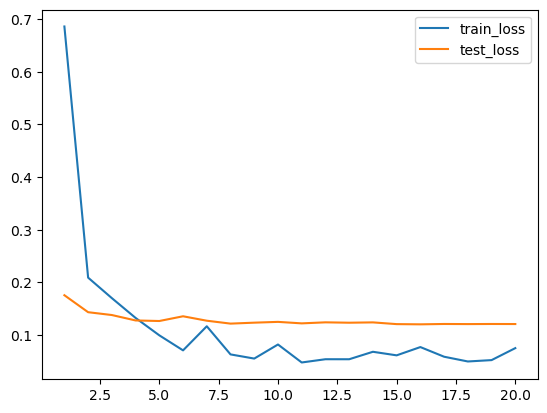

In [9]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

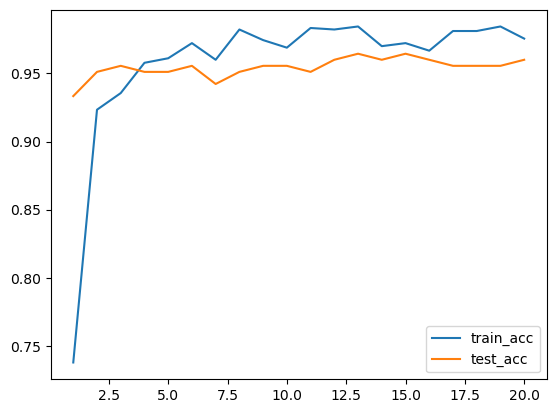

In [10]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()